## Chapter 3 Problems
This notebook attempts to solve the problems in Chapter 3 of "Aurélien Géron - Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_ Concepts, Tools, and Techniques to Build Intelligent Systems-O'Reilly Media (2022)".

In [72]:
#Import dependencies

import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import tarfile
from pathlib import Path

## Question 1

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

### Create training and test sets

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False) 

/Users/Cheks/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target
some_input = X[0] #this is a 5
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Scale and create classifier
train a KNeighbours classifier using a grid search to find the best hyperparameters

In [4]:

knn_clf = KNeighborsClassifier() #weights and n_neighbours hyperparameters

param_grid = [{'n_neighbors': [3,4,5,6],
               'weights': ['distance']}]

In [5]:
grid_search = GridSearchCV(knn_clf, 
                           param_grid= param_grid,
                           cv = 3,
                           scoring= 'accuracy'
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['distance']}],
             scoring='accuracy')

In [6]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.388008,0.045787,13.503045,1.119890,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.97040,0.96890,0.96870,0.969333,0.000759,3
1,0.395728,0.067663,12.637795,0.844099,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.97090,0.96980,0.97035,0.970350,0.000449,1
2,0.343985,0.015807,11.984878,0.186812,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.96880,0.96795,0.96905,0.968600,0.000471,4
3,0.338791,0.006227,12.043371,0.321882,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",0.97005,0.96855,0.96985,0.969483,0.000665,2


In [63]:
grid_search.score(X_test, y_test) #use .score to return the score using the given data when the best estimator has already been found

0.9714

## Question 2 - Data Augmentation

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.⁠ Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [7]:
def show_digit(input_data):
    image = input_data.reshape(28,28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

def shift(image, direction):
    shifted_image = image.copy()

    if direction == 'down':
    #if shifting down, move values 28 spaces along

        for i in range(len(image)):
            if i<=727:
                shifted_image[i+28] = image[i]
        
        for i in range(28):
            shifted_image[i] = 0

    if direction == 'up':
    #if shifting up, move values 28 spaces behind
        
        for i in range(len(image)):
            if i>=28 and i < 756:
                shifted_image[i-28] = image[i]

            if i >=756:
                shifted_image[i] = 0

    if direction == 'left':
    #if shifting left, move values 1 space back (but not left edge, i.e. multiples of 28)

        for i in range(len(image)):
            if i % 28 != 0:
                shifted_image[i-1] = image[i]
        
        for i in range(28):
            shifted_image[i*28] = 0
        
    if direction == 'right':
    #if shifting right, move values 1 space forward (but not right edge, i.e. 27 + multiples of 28)

        for i in range(len(image)):
            if i % 28 != 27:
                shifted_image[i] = image[i+1]
        
        for i in range(27):
            shifted_image[(i*28)+27] = 0
    
    return shifted_image
            
            


            


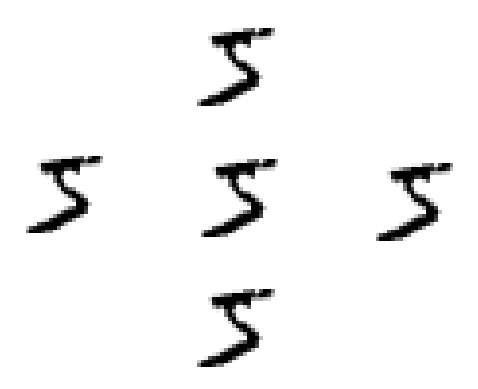

In [45]:
plt.subplot(3,3,5)
show_digit(X[0])
plt.subplot(3,3,8)
show_digit(shift(X[0], 'right'))
plt.subplot(3,3,2)
show_digit(shift(X[0], 'left'))
plt.subplot(3,3,4)
show_digit(shift(X[0], 'up'))
plt.subplot(3,3,6)
show_digit(shift(X[0], 'down'))

In [8]:
def create_shifted_copies(image):
    return shift(image, 'up'), shift(image, 'down'), shift(image, 'left'), shift(image, 'right')

In [9]:
X_train_new = list(X_train.copy())
y_train_new = list(y_train.copy())
for i in range(len(X_train)):
    for shifted_image in create_shifted_copies(X_train[i]):
        X_train_new.append(shifted_image)
        y_train_new.append(y_train[i])
        

In [14]:
X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

In [15]:
#shuffle new training set
shuffle_ids = np.random.permutation(300000)
X_train_new = X_train_new[shuffle_ids]
y_train_new = y_train_new[shuffle_ids]

In [16]:
best_model = grid_search.best_estimator_

In [17]:
best_model.fit(X_train_new, y_train_new)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [19]:
best_model.score(X_test, y_test)

0.975

## Question 3
Using the Titanic dataset. The goal is to train a classifier that can predict the Survived column based on the other columns.

In [2]:
titanic_path = Path('titanic.tgz')
if not titanic_path.is_file():
    with tarfile.open('titanic.tgz') as titanic_tarball:
        titanic_tarball.extractall()

titanic_train = pd.read_csv('titanic/train.csv')
titanic_test = pd.read_csv('titanic/test.csv')

In [3]:
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [67]:
tit_X_train = titanic_train.drop(titanic_train.columns[[0,1,3,8,10]], axis=1)
tit_y_train = titanic_train.iloc[:,1]

tit_X_train['Sex'] = ['0' if i == 'male' else '1' for i in tit_X_train['Sex'] ]
tit_embarked = tit_X_train[['Embarked']] 
one_hot_encoder = OneHotEncoder(sparse=False)
tit_embarked_one_hot = pd.DataFrame(one_hot_encoder.fit_transform(tit_embarked))
tit_X_train = tit_X_train.drop('Embarked', axis=1)
tit_X_train.join(tit_embarked_one_hot)


/Users/Cheks/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Pclass,Sex,Age,SibSp,Parch,Fare,0,1,2,3
0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,0.0
2,3,1,26.0,0,0,7.9250,0.0,0.0,1.0,0.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,0.0
4,3,0,35.0,0,0,8.0500,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,0.0,0.0,1.0,0.0
887,1,1,19.0,0,0,30.0000,0.0,0.0,1.0,0.0
888,3,1,NaN,1,2,23.4500,0.0,0.0,1.0,0.0
889,1,0,26.0,0,0,30.0000,1.0,0.0,0.0,0.0


In [68]:
#try building a random forest?
titanic_forest = RandomForestClassifier(random_state= 1610)

In [69]:
param_distribs = {'titanic_forest__max_features' : randint(low = 2, high = 20)}

In [70]:
y_prob_forest = cross_val_predict(titanic_forest, tit_X_train, tit_y_train, cv=3, method='predict_proba')

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values